# Task 1 - Decision Trees



The objective of this project is to build a classifier based on the ID3 algorithm that allows classifying instances similar to those found in the dataset "Predict students' dropout and academic success", assigning the correct value to the "Target" attribute. We incorporated hyperparameters to the algorithm defined on this course's theory program.

The learning success is measured by evaluating the error made by the algorithm when classifying instances. We will primarily use the technique of partitioning the dataset and briefly experiment with the K-Cross-validation technique as well. The performance of the implemented classifier well be compared with other implementations of decision tree-based algorithms provided by the "scikit-learn" library.

## 1. Objetivo

El objetivo de esta tarea es construir un clasificador basado en el algoritmo ID3 que permita clasificar instancias como las que se encuentran en el juego de datos "Predict students' dropout and academic success", asignando el valor correcto para el atributo "Target". Dicho algoritmo, se basa en el visto en el teórico del curso, pero incorpora dos hiperparámetros: "min_samples_split", que indica la cantidad mínima de ejemplos para generar un nuevo nodo, y "min_split_gain", que indica la ganancia mínima requerida para partir por un atributo.

El éxito del aprendizaje se mide evaluando el error cometido por el algoritmo a la hora de clasificar instancias. Utilizaremos principalmente la técnica de particionamiento del conjunto de datos para entrenar y evaluar los clasificadores generados, pero experimentando brevemente con la técnica K-Cross-validation. A su vez, compararemos el rendimiento del clasificador implementado con otras implementaciones, de otros algoritmos basados en árboles de decisiones. Dichos algoritmos son provistos por la librería "scikit-learn".


Instalamos la biblioteca scikit-learn e importamos el archivo de código

In [1]:
import lab1
!pip install scikit-learn

# 2. Diseño

En esta sección presentamos las decisiones tomadas a la hora de implementar el algoritmo.

## 2.1 Preprocesamiento de datos

### 2.1.1 Análisis del dataset

En primer lugar, para que los valores "Enrolled" y "Graduate" del atributo objetivo Target sean considerados como uno solo, se decidió modificar dichos valores por el entero 1. Para el valor "Dropout", asignamos entonces el valor 0.

Para poder aplicar el algoritmo necesitamos discretizar los elementos del corpus, para hacer esto es necesario detectar cuáles columnas de nuestro conjunto D son discretas (tienen elementos enteros) y cuáles no. Para hacer esto, aplicamos el siguiente algoritmo, que detecta cuales columnas tienen elementos contínuos. Luego, esta información la pasamos a la parte de preprocesamiento.

In [2]:
lab1.detectar_columnas_no_discretas("data.csv")


Numero de columnas en D: 37

Index(['Previous qualification (grade)', 'Admission grade',
       'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)',
       'Unemployment rate', 'Inflation rate', 'GDP'],
      dtype='object')


Obtuvimos las columnas con valores contínuos, es decir, las que debemos preprocesar. Esta información se utilizará en la siguiente sección como dato de entrada.

### 2.1.2 Preprocesamiento de columnas

En el sitio web: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success , de donde se extrajo el Dataset utilizado en esta tarea, se menciona que ya fue realizado un preprocesamiento de datos riguroso para manejar datos de anomalías, valores atípicos inexplicables y valores faltantes, asegurando que no habrá de estos últimos. Por lo tanto, se decidió considerar todos los atributos para la creación del árbol, pero discretizando aquellos atributos que poseen valores contínuos. Para determinar estos últimos, utilizamos la funcion select_dtypes de Pandas, indicando que queríamos extraer los nombres de las columnas, es decir los atributos, para las cuales había datos del tipo "float64" en ellas, obteniendo una lista con los siguientes:

- Previous qualification (grade)
- Admission grade
- Curricular units 1st sem (grade)
- Curricular units 2nd sem (grade)
- Unemployment rate
- Inflation rate
- GDP

Como el algoritmo ID3 está restringido a atributos que toman un conjunto discreto de valores, discretizamos los valores asociados a tales atributos. Cabe mencionar que los atributos:
"Curricular units 1st sem (grade)" y "Curricular units 2nd sem (grade)" pertenecen al conjunto de atributos mostrados por la sección anterior, a pesar de que en el sitio web donde fué obtenido el dataset, se especifique que los mismos toman valores enteros en el rango entre 0 y 20. Al inspeccionar el dataset pudimos observar que efectivamente los valores son reales y no enteros. Por lo tanto decidimos preprocesarlos también a pesar de tal información.

Debido a lo explicado en el párrafo anterior, debimos redefinir los atributos mencionados en el listado siguiendo las pautas indicadas en la sección 3.7.2 del libro "Machine Learning" de Mitchell. A grandes rasgos, este consiste en obtener un umbral óptimo, que divida el rango contínuo de valores en dos. Por lo tanto las instancias luego deben simplemente indicar mediante un valor booleano, representado con los enteros 0 y 1, a cual intervalo pertenecen. Dicho proceso se implementa principalmente mediante las funciones:
- preprocesar_columna: preprocesa las columnas 6, 12, 25, 31, 33, 34 y 35 del archivo .csv del dataset, correspondientes a los atributos del listado anterior.
- discretizar: se encarga de obtener el umbral que dividirá al intervalo en dos, redefiniendo el valor de cada instancia según el sub-intervalo al cual pertenecen.

Luego de dicho preprocesamiento, estaremos en condiciones de entrenar el clasificador obtenido por la implementación del algoritmo ID3 con el Dataset "Predict students' dropout and academic success".
Al realizar el preprocesamiento, es importante tener presente que los conjuntos de Entrenamiento y Testeo deben ser tomados de forma separada. Por lo tanto, aplicaremos las funciones de preprocesamiento luego de implementar la separación de estos conjuntos.

In [3]:
D = lab1.cargar_archivo("data.csv")

Dada la inconsistencia que detectamos anteriormente entre la información que se brinda sobre cuáles atributos son discretos y los que efectivamente lo eran al inspeccionar el dataset, decidimos chequear si había atributos con valores faltantes a pesar de la información proporcionada de que no había.
Observamos también que no hay elementos vacíos en nuestro corpus de entrada, ya que todos los elementos de D ejecutan correctamente la instrucción

> `D.append([float(x) for x in fila])`

En la que se asigna un número en cada elemento de cada fila del conjunto D, podemos asumir entonces que todos los datos de nuestro conjunto D son números y no strings, esto se verá reflejado más adelante en la evaluación de nuestro algoritmo.

## 2.2 Algoritmo

Para la implementación del algoritmo fué necesario crear una clase "Arbol" para manejar las estructuras generadas. Esta clase cuenta con una función de incialización que permite definir en cada nodo:


*   El índice del atributo a comparar en ese nodo. Este puede ser un entero entre 0 y 35, ya que esta es la cantidad de atributos por instancia, menos el atributo objetivo.
*   El valor del atributo correspondiente al nodo, si se trata de una hoja, será un valor booleano (0 ó 1). Dicho valor en caso de ser 0 indicará que la instancia es clasificada con el valor "Dropout" y en caso de 1 se indica que toma el valor "Enrolled" o "Graduate", ya que, por lo mencionado en la propuesta, estos dos últimos deben ser considerados como uno solo.
*   Las ramas que indican que camino se debe seguir después de realizar la evaluación.


Como sugiere el algoritmo, implementamos las funciones de entropía y ganancia que son utilizadas para seleccionar el mejor atributo en los nodos al armar el árbol. Se definen estas funciones para que sean compatibles con listas de listas, el tipo de datos manejado en nuestra implementación del algoritmo ID3.
No implementamos una versión estricta de este algoritmo, ya que incorporamos los hiperparámetros solicitados en la propuesta:


*   min_samples_split: cantidad mínima de ejemplos para generar un nuevo nodo; en caso de que no se llegue a la cantidad requerida, se debe formar una hoja.

*    min_split_gain: ganancia mínima requerida para partir por un atributo; si ningún atributo llega a ese valor, se debe formar una hoja.

## 2.3 Evaluación


Para evaluar los distintos clasificadores generados por el algoritmo y las distintas combinaciones de valores para los hiperparámetros ya mencionados, decidimos utilizar la medida Macro-F1. Dicha métrica considera tanto la precisión como el recall obtenido, lo cual es apropiado al trabajar con un conjunto de datos desbalanceado, lo que podría llevar a que obtuviéramos clasificadores con alta precisión pero con un recall muy bajo.

Asimismo, para los valores de hiperparámetros que permitían obtener una mayor Macro-F1, decidimos obtener un reporte del clasificador para un mejor análisis de las siguientes métricas:

  - Accuracy: Mide la proporción de predicciones correctas en relación con el total de predicciones realizadas.
  - Recall: Mide la capacidad del modelo para identificar correctamente todas las instancias positivas en el conjunto de datos.
  - F1 Score: Proporciona un equilibrio entre la capacidad del modelo para realizar predicciones precisas y su capacidad para identificar correctamente todas las instancias positivas.
  - Precisión: Mide la proporción de instancias positivas identificadas correctamente en relación con todas las instancias identificadas como positivas por el modelo.

Los conjuntos de entrenamiento y prueba son los siguientes:

  - X_train e y_train contienen los datos/instancias de entrenamiento y las respectivas etiquetas de los mismos.
  - X_test e y_test contienen los datos/instancias de evaluación y las respectivas etiquetas de los mismos.

La división de los datos se realiza aleatoriamente en una proporción 80-20, siendo el 80% para entrenamiento y el 20% para prueba. Esto último es sugerido en el sitio web que provee el dataset. Sin embargo, como adelantamos anteriormente, a modo de experimentación entrenamos también clasificadores utilizando todo el conjunto de datos a través de la técnica K-Cross-Validation, con 𝐾=5 para la mejor configuración de hiperparámetros obtenida mediante la técnica de particionamiento.

In [4]:
X_train,y_train,X_test,y_test = lab1.crear_conjuntos_evaluacion(D)

In [5]:
X_train = lab1.preprocesar_corpus([6,12,25,31,33,34,35],X_train)
X_test = lab1.preprocesar_corpus([6,12,25,31,33,34,35],X_test)

# 3 Experimentación

## 3.1 Experimentación con ID3

Entrenamiento y evaluación del modelo

### 3.1.1 Experimentación con ID3 utilizando particionamiento del Dataset

In [6]:
min_split_gain_range = [0, 0.001, 0.01, 0.1]
rango = [1, 10, 20, 30, 40, 50]
lab1.evaluar_id3_intercambiando_parametros(X_train, y_train,X_test,y_test,range(36),min_split_gain_range,rango)

Macro-F1  para min_samples_split=1 y min_split_gain=0 :0.7791078473451197
Macro-F1  para min_samples_split=1 y min_split_gain=0.001 :0.7791078473451197
Macro-F1  para min_samples_split=1 y min_split_gain=0.01 :0.7791078473451197
Macro-F1  para min_samples_split=1 y min_split_gain=0.1 :0.7900317971114431
Macro-F1  para min_samples_split=10 y min_split_gain=0 :0.7841369301296967
Macro-F1  para min_samples_split=10 y min_split_gain=0.001 :0.7841369301296967
Macro-F1  para min_samples_split=10 y min_split_gain=0.01 :0.7841369301296967
Macro-F1  para min_samples_split=10 y min_split_gain=0.1 :0.7858973112979786
Macro-F1  para min_samples_split=20 y min_split_gain=0 :0.7929487179487178
Macro-F1  para min_samples_split=20 y min_split_gain=0.001 :0.7929487179487178
Macro-F1  para min_samples_split=20 y min_split_gain=0.01 :0.7929487179487178
Macro-F1  para min_samples_split=20 y min_split_gain=0.1 :0.7910529458598725
Macro-F1  para min_samples_split=30 y min_split_gain=0 :0.7889090942488199
Ma

| Algoritmo | min_samples_split | min_split_gain | Macro-F1           |
|-----------|-------------------|----------------|--------------------|
| ID3       | 1                 | 0              | 0.7791078473451197 |
| ID3       | 1                 | 0.001          | 0.7791078473451197 |
| ID3       | 1                 | 0.01           | 0.7791078473451197 |
| ID3       | 1                 | 0.1            | 0.7900317971114431 |
| ID3       | 10                | 0              | 0.7841369301296967 |
| ID3       | 10                | 0.001          | 0.7841369301296967 |
| ID3       | 10                | 0.01           | 0.7841369301296967 |
| ID3       | 10                | 0.1            | 0.7858973112979786 |
| ID3       | 20                | 0              | 0.7929487179487178 |
| ID3       | 20                | 0.001          | 0.7929487179487178 |
| ID3       | 20                | 0.01           | 0.7929487179487178 |
| ID3       | 20                | 0.1            | 0.7910529458598725 |
| ID3       | 30                | 0              | 0.7889090942488199 |
| ID3       | 30                | 0.001          | 0.7889090942488199 |
| ID3       | 30                | 0.01           | 0.7889090942488199 |
| ID3       | 30                | 0.1            | 0.7870208494208495 |
| ID3       | 40                | 0              | 0.7889090942488199 |
| ID3       | 40                | 0.001          | 0.7889090942488199 |
| ID3       | 40                | 0.01           | 0.7889090942488199 |
| ID3       | 40                | 0.1            | 0.7870208494208495 |
| ID3       | 50                | 0              | 0.7790276215473066 |
| ID3       | 50                | 0.001          | 0.7790276215473066 |
| ID3       | 50                | 0.01           | 0.7790276215473066 |
| ID3       | 50                | 0.1            | 0.7790276215473066 |




Cuando examinamos las variaciones en los hiperparámetros "min_samples_split" y "min_split_gain", podemos notar que a partir de valores de "min_samples_split" mayores o iguales a 30, el rendimiento de los clasificadores no varía en gran medida cuando se utiliza el mismo "min_split_gain". Sin embargo, para "min_samples_split=20" obtenemos los mejores resultados en general.

Por otro lado, cuando consideramos el valor 1 para el hiperparámetro "min_samples_split", estamos aplicando el algoritmo ID3 original, pues utilizamos todas las instancias para la construcción del árbol. Esto puede estar provocando sobreajuste, causando que el desempeño del clasificador disminuya ante instancias no vistas, como pudimos observar. De este modo, valores más altos de dicho hiperparámetro pueden ayudar a prevenir el sobreajuste, a reducir la profundidad del árbol, ya que se requieren más muestras para justificar la división de un nodo. Sin emabrgo, notamos que el valor 50 ya es un número excesivo debido a que el otro hiperparámetro no modifica significativamente los valores mientras varía. A su vez, en relación al punto anterior, valores altos hacen que se reduzca el tiempo de entrenamiento; sin embargo, puede conducir a un subajuste debido a que el clasificador no sea capaz de capturar suficientemente los patrones en los datos.

Por otra parte, al variar el valor de "min_split_gain", notamos que valores más cercanos al cero, incluido este, no provocaban grandes variaciones en las Macro-F1 obtenidas, llegando incluso a obtenerse los mismos resultados de forma general para los valores 0, 0.001 y 0.01. Para estos casos, es probable que al ser valores bastante pequeños, se esté generando el mismo árbol y, en consecuencia, obteniendo las mismas Macro-F1. Debido a esto, se deduce que valores muy cercanos a cero no son apropiados para realizar podas en el árbol.

Por otro lado, para el valor 0.1 que fue el mayor considerado, para valores de "min_samples_split" como 1, 10 y 20 se obtiene una leve mejora, pero para valores mayores a estos no. Dicho valor ocasiona que el algoritmo retorne un árbol de clasificación de forma más temprana y menos profundo. Esto se debe a que al establecer un umbral más alto de ganancia, estamos incentivando que el modelo realice divisiones que tengan un impacto significativo en la función objetivo, ignorando divisiones que proporcionen mejoras menores, lo que reduce a su vez el tiempo de entrenamiento.

En líneas generales, observamos que el valor de la Macro-F1 varía en un rango entre 0.779 y 0.793. Dicho valor mínimo se obtiene utilizando el valor "min_samples_split=1" y los valores 0, 0.001 y 0.01 para min_split_gain. Por otro lado, el máximo para los valores considerados se obtiene con "min_samples_split=20" y los valores 0, 0.001 y 0.01 para min_split_gain. Ahora analicemos más métricas correspondientes a uno de estos últimos clasificadores, tomando "min_split_gain=0". Los datos obtenidos son:


In [7]:
data_completo = lab1.armar_data(X_train,y_train)
treeOpt = lab1.id3(X_train, y_train,data_completo, range(36),36, 20 , 0)
lab1.imprimir_resultados(treeOpt, X_test, y_test)

Accuracy: 0.8281
Macro-F1: 0.7929487179487178
              precision    recall  f1-score   support

         0.0       0.84      0.61      0.71       300
         1.0       0.83      0.94      0.88       584

    accuracy                           0.83       884
   macro avg       0.83      0.78      0.79       884
weighted avg       0.83      0.83      0.82       884



|             | Precision | Recall | F1-Score | Support |
|-------------|-----------|--------|----------|---------|
| 0           |    0.84   |  0.61  |   0.71   |   300   |
| 1           |    0.83   |  0.94  |   0.88   |   584   |
| accuracy    |           |        |   0.83   |   884   |
| macro avg   |    0.83   |  0.78  |   0.79   |   884   |
| weighted avg|    0.83   |  0.83  |   0.82   |   884   |


En esta tabla, es interesante notar que el F1-score es considerablemente más alto para la clase 1, lo que sugiere un rendimiento superior en la clasificación de esta categoría en particular. Esto último se debe probablemente a que el número de ocurrencias reales de la clase en el conjunto de datos analizado es mayor respecto a las etiquetadas con el target "0", tal como lo indica la columna "Support" de la tabla anterior. Por lo tanto, al contar con más ejemplos, en este caso, el clasificador aprende de mejor manera a clasificar instancias que se corresponden con la clase 1. Recordemos que el target "1" se corresponde con las instancias con el valor de atributo objetivo original "Enrolled" y "Graduate", mientras que el "0" únicamente con el valor de atributo objetivo "Dropout", generándose de este modo un desbalanceo que podemos notar en el conjunto de prueba, en los valores de la columna correspondiente a "Support".


### 3.1.2 Experimentación con ID3 utilizando K-Cross-Validation

Ahora, analicemos las métricas que se obtienen al entrenar un Clasificador ID3 utilizando 5-Cross-Validation para "min_samples_split=20" y "min_split_gain=0", que fueron los valores que dieron mejores resultados en la sección anterior para la partición del conjunto de datos. Los resultados son:



In [14]:
lab1.ID3_CrossValidation(X_train, y_train, X_test, y_test, 5, 20, 0)

Macro-F1 para cada fold:  [0.8298142379139264, 0.800748067792822, 0.782025508573863, 0.8115733854716438, 0.8042840537997454]
Media de la Macro-F1: 0.8056890507104001


- **Macro-F1 para cada fold**:
  - Fold 1: 0.8298
  - Fold 2: 0.8007
  - Fold 3: 0.7820
  - Fold 4: 0.8115
  - Fold 5: 0.8043

- **Media de la Macro-F1**: 0.8057


Podemos observar que en este caso, la media de la Macro-F1 es levemente superior a la obtenida anteriormente, ahora es de aproximadamente 0.8057. Por lo tanto, no vemos mejoras significativas al utilizar esta técnica para entrenar el modelo en lugar de la sugerida en el sitio web donde se obtuvo el dataset. Sin embargo, a modo de experimentación, volveremos a entrenar con dicha técnica los algoritmos DecisionTree y RandomForest de scikit-learn. Para los mismos, obtendremos mejores resultados, como veremos a continuación.

Se debe tener en cuenta que al realizar K-Cross-Validation es conveniente realizar un "shuffle" o barajado del corpus, por lo que es probable que los resultados a la hora de replicar sean levemente distintos en términos de la Macro-F1 mostrada en la salida de la celda anterior.

## 3.2 Experimentación con *DecisionTree*

### 3.2.1 Experimentacion con *DecisionTree* utilzando particionamiento del *Dataset*

Tanto la implementación de DecisionTree como la de RandomForest que proporciona scikit-learn hacen referencia al hiperparámetro "min_split_gain" como "min_impurity_decrease". Es decir, ambos indican la ganancia mínima requerida para dividir un atributo, y si ningún atributo alcanza ese valor, se debe formar una hoja.


In [15]:
lab1.evaluar_DecisionTree(X_train, y_train, X_test, y_test,[2,10,20,30,40,50],[0,0.001,0.01,0.1])

Evaluación para Decision Tree:
Macro-F1  para min_samples_split=2 y min_impurity_decrease=0 :      0.7704223744292238
Macro-F1  para min_samples_split=2 y min_impurity_decrease=0.001 :      0.8080992512147688
Macro-F1  para min_samples_split=2 y min_impurity_decrease=0.01 :      0.795547385620915
Macro-F1  para min_samples_split=2 y min_impurity_decrease=0.1 :      0.7804635761589404
Macro-F1  para min_samples_split=10 y min_impurity_decrease=0 :      0.7872533197429146
Macro-F1  para min_samples_split=10 y min_impurity_decrease=0.001 :      0.8080992512147688
Macro-F1  para min_samples_split=10 y min_impurity_decrease=0.01 :      0.795547385620915
Macro-F1  para min_samples_split=10 y min_impurity_decrease=0.1 :      0.7804635761589404
Macro-F1  para min_samples_split=20 y min_impurity_decrease=0 :      0.7928892077008516
Macro-F1  para min_samples_split=20 y min_impurity_decrease=0.001 :      0.8080992512147688
Macro-F1  para min_samples_split=20 y min_impurity_decrease=0.01 :      0

En la siguiente tabla, podremos ver un resumen de los valores de Macro-F1 obtenidos para las distintas combinaciones de valores de hiperparámetros, donde se consideran los mismos valores que se utilizaron para evaluar la implementación de ID3. Cabe mencionar que esta implementación de DecisionTree que proporciona scikit-learn no permite el valor 1 para "min_samples_split", por lo que se utiliza el valor 2 para analizar el caso en el que el algoritmo considera la mayoría de las instancias del conjunto de entrenamiento para la construcción del árbol de decisión.

| Algoritmo       | min_samples_split | min_impurity_decrease | Macro-F1                  |
|-----------------|-------------------|-----------------------|--------------------------|
| Decision Tree   | 2                 | 0                     | 0.7704223744292238       |
| Decision Tree   | 2                 | 0.001                 | 0.8080992512147688       |
| Decision Tree   | 2                 | 0.01                  | 0.795547385620915        |
| Decision Tree   | 2                 | 0.1                   | 0.7804635761589404       |
| Decision Tree   | 10                | 0                     | 0.7872533197429146       |
| Decision Tree   | 10                | 0.001                 | 0.8080992512147688       |
| Decision Tree   | 10                | 0.01                  | 0.795547385620915        |
| Decision Tree   | 10                | 0.1                   | 0.7804635761589404       |
| Decision Tree   | 20                | 0                     | 0.7928892077008516       |
| Decision Tree   | 20                | 0.001                 | 0.8080992512147688       |
| Decision Tree   | 20                | 0.01                  | 0.795547385620915        |
| Decision Tree   | 20                | 0.1                   | 0.7804635761589404       |
| Decision Tree   | 30                | 0                     | 0.7986971059610285       |
| Decision Tree   | 30                | 0.001                 | 0.8080992512147688       |
| Decision Tree   | 30                | 0.01                  | 0.795547385620915        |
| Decision Tree   | 30                | 0.1                   | 0.7804635761589404       |
| Decision Tree   | 40                | 0                     | 0.8013824458453934       |
| Decision Tree   | 40                | 0.001                 | 0.8096002020157007       |
| Decision Tree   | 40                | 0.01                  | 0.795547385620915        |
| Decision Tree   | 40                | 0.1                   | 0.7804635761589404       |
| Decision Tree   | 50                | 0                     | 0.80242656449553         |
| Decision Tree   | 50                | 0.001                 | 0.8035751833895793       |
| Decision Tree   | 50                | 0.01                  | 0.795547385620915        |
| Decision Tree   | 50                | 0.1                   | 0.7804635761589404       |



Como podemos ver, para min_impurity_decrease=0.001 y los valores 2, 10, 20 y 30 de min_samples_split se obtiene la segunda mejor Macro-F1: 0.8081 y en min_samples_split=40 con el mismo valor de min_impurity_decrease se obtiene la mejor Macro-F1: 0.8096. Por lo tanto, podemos observar que este algoritmo se comporta mejor con valores bajos de min_impurity_decrease, donde en particular 0.001 presenta buenos resultados en general, superiores a cualquiera de los obtenidos con ID3.

El valor más bajo, 0.770, se obtiene con min_samples_split=2 y min_impurity_decrease=0.

### 3.2.2 Experimentación con *DecisionTree* utilizando *K-Cross-Validation*

Luego, solicitamos un reporte de las demás métricas de evaluación para una de las configuraciones de hiperparámetros con las que se obtuvo mejor Macro-F1. En este caso, tomaremos "min_samples_split=20". Además, a modo de experimentación, en dicho reporte analizamos el clasificador que se obtiene si entrenamos mediante la técnica de 5-Cross-Validation. En esta técnica estaremos utilizando todo el conjunto de datos para entrenar y evaluar. A continuación, los resultados obtenidos son:

- **Macro-F1 aplicando técnica de particionamiento 80/20 del dataset para entrenar y testear**: 0.8081

|          | Precision | Recall | F1-Score | Support |
|----------|-----------|--------|----------|---------|
| 0.0      |    0.80   |  0.68  |   0.74   |   300   |
| 1.0      |    0.85   |  0.91  |   0.88   |   584   |
| accuracy |           |        |   0.83   |   884   |
| macro avg|    0.83   |  0.80  |   0.81   |   884   |
| weighted avg|  0.83   |  0.83  |   0.83   |   884   |




Luego de aplicar 5-Cross-Validation:

- **Macro-F1 para cada fold**:
  - Fold 1: 0.8386
  - Fold 2: 0.8537
  - Fold 3: 0.8221
  - Fold 4: 0.8370
  - Fold 5: 0.8152

- **Media de la Macro-F1**: 0.8333
- **Desviación estándar de la Macro-F1**: 0.0135


Como se puede observar, el clasificador resultante de entrenar mediante 5-Cross-Validation brinda una levemente mejor Macro-F1 y en un tiempo de ejecucion similar. Al igual que como fue analizado para el caso de ID3, las metricas respecto a la clase 1 son mejores respecto a las de la clase 0, por los mismos motivos ya expuestos.

In [ ]:
lab1.reporte_DecisionTree(X_train, y_train, X_test, y_test, 20, 0.001)

              precision    recall  f1-score   support

         0.0       0.80      0.68      0.74       300
         1.0       0.85      0.91      0.88       584

    accuracy                           0.83       884
   macro avg       0.83      0.80      0.81       884
weighted avg       0.83      0.83      0.83       884

Macro-F1 aplicando tecnica de particionamiento 80/20 del dataset para entrenar y testear: 0.8080992512147688
Luego de aplicar 5-Cross-Validation:
Macro-F1 para cada fold: [0.83860947 0.85373571 0.82213106 0.83705566 0.81522388]
Media de la Macro-F1: 0.8333511565968632
Desviación estándar de la Macro-F1: 0.013501053042408728


## 3.3 Experimentación con *RandomForest*

### 3.3.1 Experimentación con RandomForest utilzando particionamiento del Dataset

In [17]:
lab1.evaluar_RandomForest(X_train, y_train, X_test, y_test,[2,10,20,30,40,50],[0,0.001,0.01,0.1])

Evaluación para Random Forest:
Macro-F1  para min_samples_split=2 y min_impurity_decrease=0 :      0.8302770522179805
Macro-F1  para min_samples_split=2 y min_impurity_decrease=0.001 :      0.8259044612320066
Macro-F1  para min_samples_split=2 y min_impurity_decrease=0.01 :      0.7860352538805577
Macro-F1  para min_samples_split=2 y min_impurity_decrease=0.1 :      0.39782016348773847
Macro-F1  para min_samples_split=10 y min_impurity_decrease=0 :      0.8197515980919637
Macro-F1  para min_samples_split=10 y min_impurity_decrease=0.001 :      0.8205885669184803
Macro-F1  para min_samples_split=10 y min_impurity_decrease=0.01 :      0.7860352538805577
Macro-F1  para min_samples_split=10 y min_impurity_decrease=0.1 :      0.39782016348773847
Macro-F1  para min_samples_split=20 y min_impurity_decrease=0 :      0.8208013541847
Macro-F1  para min_samples_split=20 y min_impurity_decrease=0.001 :      0.8160332971407891
Macro-F1  para min_samples_split=20 y min_impurity_decrease=0.01 :      

| Algoritmo      | min_samples_split | min_impurity_decrease | Macro-F1                  |
|----------------|-------------------|-----------------------|--------------------------|
| Random Forest  | 2                 | 0                     | 0.8302770522179805       |
| Random Forest  | 2                 | 0.001                 | 0.8259044612320066       |
| Random Forest  | 2                 | 0.01                  | 0.7860352538805577       |
| Random Forest  | 2                 | 0.1                   | 0.39782016348773847      |
| Random Forest  | 10                | 0                     | 0.8197515980919637       |
| Random Forest  | 10                | 0.001                 | 0.8205885669184803       |
| Random Forest  | 10                | 0.01                  | 0.7860352538805577       |
| Random Forest  | 10                | 0.1                   | 0.39782016348773847      |
| Random Forest  | 20                | 0                     | 0.8208013541847          |
| Random Forest  | 20                | 0.001                 | 0.8160332971407891       |
| Random Forest  | 20                | 0.01                  | 0.7860352538805577       |
| Random Forest  | 20                | 0.1                   | 0.39782016348773847      |
| Random Forest  | 30                | 0                     | 0.8205344081206151       |
| Random Forest  | 30                | 0.001                 | 0.8186699247028315       |
| Random Forest  | 30                | 0.01                  | 0.7860352538805577       |
| Random Forest  | 30                | 0.1                   | 0.39782016348773847      |
| Random Forest  | 40                | 0                     | 0.8205344081206151       |
| Random Forest  | 40                | 0.001                 | 0.8152560083594567       |
| Random Forest  | 40                | 0.01                  | 0.7860352538805577       |
| Random Forest  | 40                | 0.1                   | 0.39782016348773847      |
| Random Forest  | 50                | 0                     | 0.8236071624145769       |
| Random Forest  | 50                | 0.001                 | 0.8205344081206151       |
| Random Forest  | 50                | 0.01                  | 0.7891243520595318       |
| Random Forest  | 50                | 0.1                   | 0.39782016348773847      |


Como podemos ver en la anterior tabla, para min_impurity_decrease=0.1 se obtienen las peores Macro-F1, 0.735, independientemente del valor de min_samples_split. La posible razón a tal suceso, sigue siendo la mencionada cuando se analizaron valores altos de dicho hiperparámetro en el algoritmo ID3.

Luego, para min_samples_split=30 y min_impurity_decrease=0 se obtiene la mejor Macro-F1: 0.829,

### 3.2.2 Experimentación con RandomForest utilizando *K-Cross-Validation*

Solictamos un reporte de las demas metricas de evaluación para la mejor configuracion de hiperparametros mencionada anteriormente. A su vez, a modo de experimentación, en dicho reporte analizamos el clasificador que se obtiene si entrenamos mediante la tecnica de 5-Cross-Validation. Luego, los resultados obtenidos son:



**Macro-F1 aplicando técnica de particionamiento 80/20 del dataset para entrenar y testear**: **0.8291**


| Label         | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| 0             | 0.83      | 0.69   | 0.75     | 300     |
| 1             | 0.85      | 0.93   | 0.89     | 584     |
| accuracy      | -         | -      | 0.85     | 884     |
| macro avg     | 0.84      | 0.81   | 0.82     | 884     |
| weighted avg  | 0.84      | 0.85   | 0.84     | 884     |


Luego de aplicar 5-Cross-Validation:

**Macro-F1 para cada fold**:
- Fold 1: **0.8562**
- Fold 2: **0.8608**
- Fold 3: **0.8359**
- Fold 4: **0.8494**
- Fold 5: **0.8341**

**Media de la Macro-F1**:
- Valor: **0.8473**

**Desviación estándar de la Macro-F1**:
- Valor: **0.0107**

Como indican los datos, se obtiene una mejora en la Media de la Macro-F1 respecto a si se utiliza particionamiento para entrenar.

In [18]:
lab1.reporte_RandomForest(X_train, y_train, X_test, y_test, 30, 0)

              precision    recall  f1-score   support

         0.0       0.83      0.69      0.75       300
         1.0       0.85      0.93      0.89       584

    accuracy                           0.85       884
   macro avg       0.84      0.81      0.82       884
weighted avg       0.84      0.85      0.84       884

Macro-F1 aplicando tecnica de particionamiento 80/20 del dataset para entrenar y testear: 0.8205344081206151
Luego de aplicar 5-Cross-Validation:
Macro-F1 para cada fold: [0.85622558 0.86081258 0.83591935 0.84948031 0.83410611]
Media de la Macro-F1: 0.8473087878010945
Desviación estándar de la Macro-F1: 0.010682764161921238


## 3.4 Resumen y análisis gráfico

### 3.4.1 Resumen de información obtenida

A continuación, se presenta en forma resumida una tabla que presenta los valores de hiperparámetros correspondientes a modelos para los cuales se obtuvieron mejores valores de Macro-F1, y que fueron entrenados mediante la tecnica de particionamiento del dataset:

| Algoritmo     | Mejor Macro-F1         | Hiperparámetros (min_samples_split, min_split_gain)                                              |
|---------------|------------------------|--------------------------------------------------------------|
| ID3           | 0.7929487179487178     | (20, 0) o (20,0.01) o (20,0.001)                                                    |
| Decision Tree | 0.8096002020157007     | (40, 0.001)   |
| Random Forest | 0.8302770522179805     | (2, 0)                                                       |


A continuación, resumimos en una tabla como se comportan los algoritmos frente a la combinación de valores de hiperparámetros que resultó óptima, dentro del conjunto de valores considerados, para los demás algoritmos evaluados. En el caso de ID3 para el cual había 3 combinaciones óptimas posibles, se elige el par ("min_samples_split"=20,"min_split_gain"=0):

| Algoritmo     | ID3 (20, 0) | Decision Tree (40, 0.001) | Random Forest (2, 0) |
|---------------|----------------|---------------------------|-----------------------|
| ID3           | 0.7929487179487178   | 0.7889090942488199                     | 0.7791078473451197   |
| Decision Tree | 0.7928892077008516   | 0.8126168084788774        | 0.7704223744292238     |
| Random Forest | 0.8208013541847   | 0.8152560083594567        | 0.8302770522179805    |




Como se puede notar dadas las dos tablas anteriores, las Macro-F1 que se obtienen en las mejores configuraciones halladas de los clasificadores construidos por los algoritmos ID3 y DecisionTree, difieren aproximadamente en 0.02. Por otro lado, RandomForest obtiene una mejora de 0.017 aproximadamente respecto a DesicionTree, que fue el segundo mejor clasificador en términos de la anterior métrica. Además, observamos que RandomForest se puede comportar mejor que los otros algoritmos incluso sin utilizar los valores que le permiten obtener mejor rendimiento.

Relacionado al argumento anterior, presentamos otras medidas tomadas al testear los modelos basados en los hiperparámetros que lograban la mayor Macro-F1 al evaluar el conjunto de test:

| Algoritmo      | Clase/Métrica | Precision | Recall | F1-Score | Support |
|----------------|---------------|-----------|--------|----------|---------|
| ID3            | 0             | 0.84      | 0.61   | 0.71     | 300     |
| ID3            | 1             | 0.83      | 0.94   | 0.88     | 584     |
| ID3            | Macro avg     | 0.83      | 0.78   | 0.79     | 884     |
| Decision Tree  | 0             | 0.80      | 0.68   | 0.74     | 300     |
| Decision Tree  | 1             | 0.85      | 0.91   | 0.88     | 584     |
| Decision Tree  | Macro avg     | 0.83      | 0.80   | 0.81     | 884     |
| Random Forests | 0             | 0.83      | 0.69   | 0.75     | 300     |
| Random Forests | 1             | 0.85      | 0.93   | 0.89     | 584     |
| Random Forests | Macro avg     | 0.84      | 0.81   | 0.82     | 884     |


Analizando la tabla anterior, vemos que la clase 1 obtiene mejores valores en las métricas al tener el clasificador más instancias pertenecientes a esa clase, tanto para entrenar como evaluar. Nuevamente, al considerar las medidas macro, vemos como RandomForest es superior a los otros dos. También podemos notar que DecisionTree logra mejores resultados respecto a ID3 para los experimentos realizados.

### 3.4.2 Análisis Gráfico

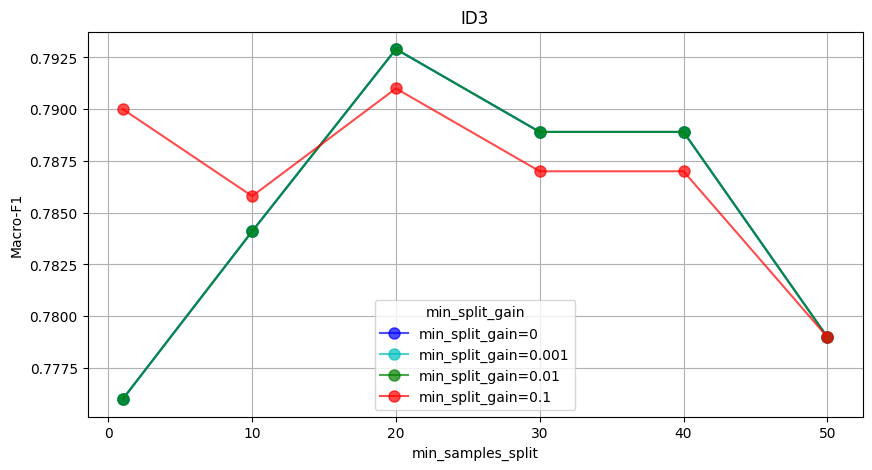

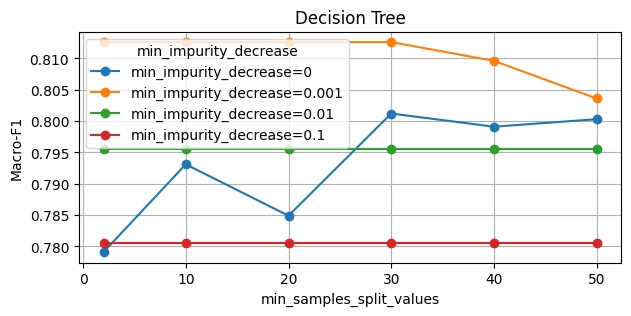

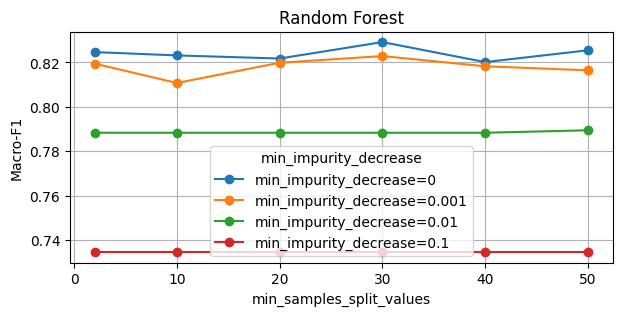

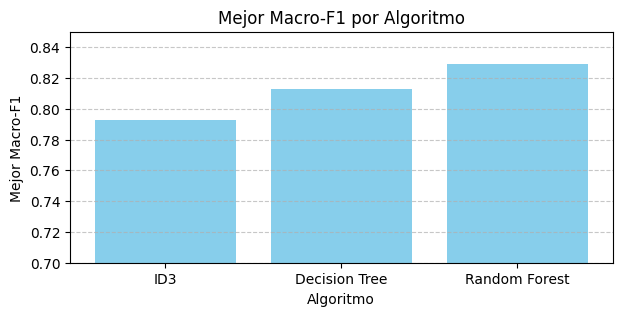

In [21]:
lab1.crear_analisis_grafico()

En las gráficas anteriores podemos observar los comportamientos esperados, dado el análisis hecho en la sección previa. En el de ID3, vemos que el trazo correspondiente a los tres valores menores de "min_split_gain" coincide. Por otro lado, tanto en el gráfico de DecisionTree como en el de RandomForest observamos de forma más clara como valores grandes de "min_impurity_decrease" pueden hacer que el árbol se construya de forma más temprana, perdiendo rendimiento debido al subajuste ya explicado anteriormente. Tal es el caso, ya que a pesar de que el valor del otro hiperparámetro sea modificado, el rendimiento es el mismo ya que los árboles construidos coinciden muy probablemente.

En cuanto al ultimo gráfico, simplemente vemos reflejado la superioridad del algoritmo RandomForest frente a los otros, y la de DecisionTree frente a ID3. Esto último se puede afirmar para los experimentados realizados junto con los valores de hiperparámetros elegidos, debido a los valores de Macro-F1 obtenidos.

# 4. Conclusión

- Los mejores resultados se obtuvieron con el árbol que construye el algoritmo RandomForest, en su versión provista por la biblioteca scikit-learn. En particular para  "min_samples_split=2" y "min_impurity_decrease=0". Luego, DecisionTree obtuvo el segundo mejor rendimiento, y por último nuestra implementación de ID3. Esto para las configuraciones de valores de hiperparámetros consideradas en la sección 3.4.1. Este último rendimiento era esperado al ser ID3 uno de los primeros algoritmos de árboles de decisión, desarrollado 11 años antes que RandomForest.

- La utilización de hiperparámetros para implementar el algoritmo ID3 resultó útil, ya que cuando les asignamos valores a los mismos tal que el comportamiento resultase igual al del algoritmo ID3 original, es decir utilizando "min_samples_split=1" y "min_impurity_decrease=0", la Macro-F1 obtenida fué la peor (0.779).

- Entrenar los clasificadores utilizando la técnica de K-Cross-Validation en lugar de particionamiento del Dataset, no implicó mejoras significativas a la hora de clasificar, aunque en todos los casos aumentó la Media de la Macro-F1. Dado que el número de instancias en el Dataset no es grande, cualquiera de las dos técnicas permitió entrenar los modelos muy rápidamente.

- Si bien los resultados para RandomForest son muy buenos, indicando un buen equilibrio entre precisión y recall, ninguno de los algoritmos permite diferenciar instancias clasificadas como "Enrolled" de insancias clasificadas como "Graduate". Estos dos valores, que junto con "Dropout" eran los que tomaba el atributo objetivo, al ser considerados como uno solo se pierde la diferenciación entre instancias con tales clases. Recordamos que esto sucede en las versiones trabajadas de los algoritmos y para el preprocesamiento realizado. Otros metodos de clasificación permiten fácilemnte trabajar con múltiples clases objetivos.

- En cuanto al hiperparámetro "min_split_gain", también llamado "min_impurity_decrease", la utilización de valores menores o mayores repercute fuertemente en el rendimiento del clasificador. Esto se da, debido a que al establecer un umbral más alto de ganancia, estamos incentivando que el modelo realice divisiones que tengan un impacto significativo en la función objetivo, ignorando divisiones que proporcionen mejoras menores, lo que reduce a su vez el tiempo de entrenamiento. En cambio, valores más cercanos al cero, incluido este, no provocaban grandes variaciones en las Macro-F1 obtenidas, llegando incluso a obtenerse los mismos resultados de forma general para los valores 0, 0.001 y 0.01. Para estos casos, es probable que al ser valores bastante chicos, se estuviera generando el mismo árbol y en consecuencia obteniendo las mismas Macro-F1. Debido a esto se deduce que valores muy cercanos a cero no son apropiados para realizar podas en la construcción del árbol. Al utilizar el valor "min_split_gain" = 0.1 en el algoritmo RandomForests, observamos que el rendimiento decae significativamente retornando valores de Macro-F1 de aproximadamente 0.39. Esto se debe a que se crean muchos árboles similares en el bosque, pues las divisiones de menor ganancia se evitarán en una cantidad muy alta de árboles, produciendo una reducción en la "diversidad" del bosque, empeorando el rendimiento del algoritmo.

- En cuanto al hiperparámetro "min_samples_split", utilizar valores chicos puede provocar sobreajuste, provocando que el desempeño del clasificador disminuya ante instancias no vistas, como pudimos observar. De este modo, valores mas altos de tal hiperparámetro pueden ayudar a prevenir el sobreajuste y a reducir la profundidad del árbol, ya que se requieren más muestras para justificar la división de un nodo. A su vez en relación al argumento anterior, valores altos hacen que se reduzca el tiempo de entrenamiento, sin embargo puede conducir a un subajuste debido a que el clasificador no sea capaz de capturar suficientemente los patrones en los datos.

- En cuanto al preprocesamiento, en caso de que no se garantice la ausencia de valores faltantes en el Dataset, habría que considerar alguna medida extra dado que el algoritmo implementado no está pensado para funcionar correctamente en dichos casos.

## 5. Bibliografia/Webgrafia

- UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

- Mitchell, T. M. (1997). Machine Learning. McGraw Hill.
